# Taller Aprendizaje-No Supervisado
Para esta competencia se debe construir un sistema que permita recuperar imágenes por contenido: dada una imagen de referencia q (query), éste debe encontrar las imágenes de una base de datos que son semánticamente similares a q.

Este problema se conoce en la literatura como CBIR y tiene varias aplicaciones. Una de ellas consiste en recuperar imágenes médicas similares a las que se acaba de tomar un paciente para apoyar el diagnóstico de un especialista. Esta idea está siendo explorada por investigadores UTFSM en un Proyecto FONDEF cuyo objetivo es construir un sistema denominado "Proximity".

Para simular condiciones del mundo real, se pone a disposición de los competidores una base de datos donde sólo una pequeña parte de las imágenes tiene anotaciones de alto nivel que permitan guiar el entrenamiento. Se espera que los competidores implementen mecanismos de aprendizaje no-supervisado para compensar esta limitación.


In [ ]:
!wget www.inf.utfsm.cl/~jnancu/database-full.zip

--2022-07-27 08:44:25--  http://www.inf.utfsm.cl/~jnancu/database-full.zip
Resolving www.inf.utfsm.cl (www.inf.utfsm.cl)... 200.1.19.11, 2800:270:c::11
Connecting to www.inf.utfsm.cl (www.inf.utfsm.cl)|200.1.19.11|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.inf.utfsm.cl/~jnancu/database-full.zip [following]
--2022-07-27 08:44:25--  https://www.inf.utfsm.cl/~jnancu/database-full.zip
Connecting to www.inf.utfsm.cl (www.inf.utfsm.cl)|200.1.19.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4378195392 (4.1G) [application/zip]
Saving to: ‘database-full.zip’

database-full.zip   100%[===================>]   4.08G  26.1MB/s    in 2m 41s  

2022-07-27 08:47:06 (25.9 MB/s) - ‘database-full.zip’ saved [4378195392/4378195392]



In [ ]:
!unzip database-full.zip -d images

In [ ]:
import os

path = "/content/images/database-full"
len(os.listdir(path))

31784

Revisamos los datos y en general son imagenes de diversa índole, usualmente con personas en ellas

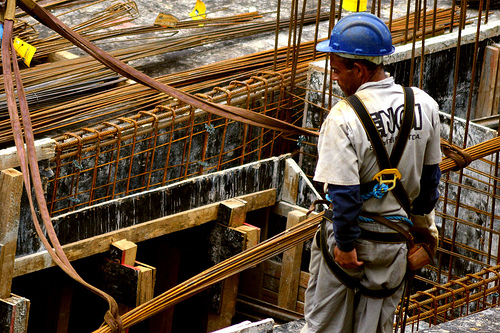

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

load_img(os.path.join(path, os.listdir(path)[12]))

# Modelo AutoEncoders I: 64 x 64 bit

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, BatchNormalization,Dense
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.datasets import mnist
import keras, keras.layers as L
from keras.models import load_model
from sklearn.metrics import label_ranking_average_precision_score
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
import time
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import cv2

In [ ]:
path = "/content/images/database-full/"
dim = 64
ch = 3

In [ ]:
img_data = list()
image_names = os.listdir(path)

In [ ]:
size = len(os.listdir(path))
image_names = [ ' image'+str(id)+'.jpg' for id in range(size) if id != 11396]#[*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*]

In [ ]:
image_names[0]

' image0.jpg'

In [ ]:
for image_name in image_names:
    try:
        img = cv2.imread(path+image_name, 1)
        rgb_img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        rgb_img=cv2.resize(rgb_img, (dim,dim))
        img_data.append(img_to_array(rgb_img))
    except:
        print("failed")

In [ ]:
img_data=np.array(img_data)

In [ ]:
img_final=np.reshape(img_data, (len(img_data),dim, dim, ch))
img_final=img_final.astype('float32')/255

In [ ]:
p = int(len(img_data)*(8/10))

x_train, x_test = img_final[:p,],img_final[p:,]

In [ ]:
# matplotlib displays color in BGR format, we are converting that to RGB
def plot_rgb_img(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
del img_data
del img_final

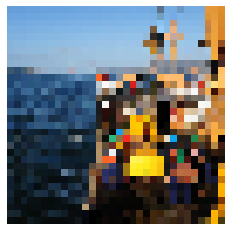

In [ ]:
plot_rgb_img(x_train[6])

In [ ]:
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [ ]:
x_train.shape

(25426, 32, 32, 3)

In [ ]:
def build_deep_autoencoder(img_shape, code_size):
    H,W,C = img_shape
    
    # encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    
    encoder.add(L.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=48, kernel_size=(3, 3), activation='relu', padding='same'))
    encoder.add(L.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size,))
    encoder.summary()

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(8*8*code_size))
    decoder.add(L.Reshape((8,8,code_size)))
    decoder.add(L.UpSampling2D((4, 4)))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    decoder.add(L.Conv2D(3, (3, 3), activation="sigmoid", padding="same"))
    decoder.summary()
    
    return encoder, decoder

In [ ]:
IMG_SHAPE = x_train.shape[1:]

In [ ]:
IMG_SHAPE

(32, 32, 3)

In [ ]:
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=1500)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 8, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 8, 8, 48)          55344     
                                                                 
 conv2d_31 (Conv2D)          (None, 8, 8, 32)        

In [ ]:
inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

In [ ]:
gaussian_early_stop = EarlyStopping(monitor='val_loss', patience=3)
autoencoder.fit(x=x_train_noisy, y=x_train, epochs=30,
                validation_data=[x_test_noisy, x_test],
                callbacks=[gaussian_early_stop],
                verbose=1, batch_size=16)

Epoch 1/30
1590/1590 [==============================] - 56s 35ms/step - loss: 0.0316 - val_loss: 0.0268
Epoch 2/30
1590/1590 [==============================] - 55s 35ms/step - loss: 0.0248 - val_loss: 0.0238
Epoch 3/30
1590/1590 [==============================] - 55s 35ms/step - loss: 0.0232 - val_loss: 0.0229
Epoch 4/30
1590/1590 [==============================] - 55s 35ms/step - loss: 0.0222 - val_loss: 0.0225
Epoch 5/30
1590/1590 [==============================] - 55s 35ms/step - loss: 0.0215 - val_loss: 0.0222
Epoch 6/30
1590/1590 [==============================] - 55s 35ms/step - loss: 0.0208 - val_loss: 0.0218
Epoch 7/30
1590/1590 [==============================] - 55s 35ms/step - loss: 0.0203 - val_loss: 0.0214
Epoch 8/30
1590/1590 [==============================] - 55s 35ms/step - loss: 0.0197 - val_loss: 0.0213
Epoch 9/30
1590/1590 [==============================] - 55s 35ms/step - loss: 0.0192 - val_loss: 0.0214
Epoch 10/30
1590/1590 [==============================] - 55s 35m

In [ ]:
encoder.save('encoder.h5')
decoder.save('decoder.h5')
autoencoder.save('autoencoder.h5')

# Visualización de datos

In [ ]:
from PIL import Image

def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))


def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
      axs[0, i].imshow(img)
      axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//15,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

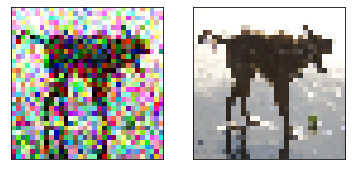

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision.transforms as T
from torchvision.io import read_image


show([x_test_noisy[0], x_test[0]])

Convolutional autoencoder MSE: 0.021437253803014755


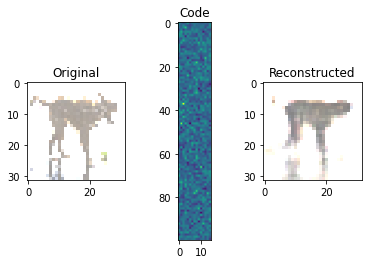

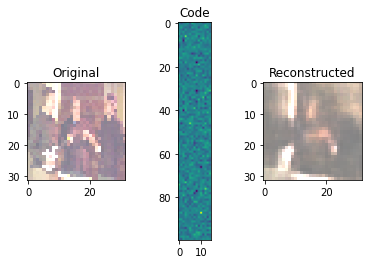

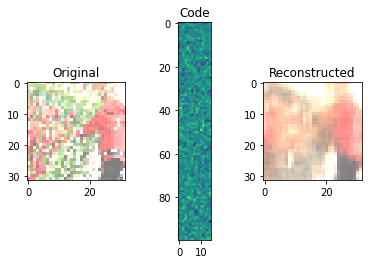

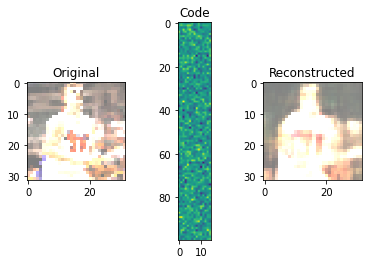

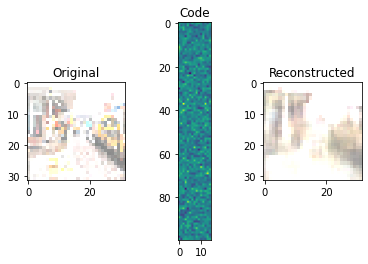

In [ ]:
reconstruction_mse = autoencoder.evaluate(x_test_noisy, x_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)
for i in range(5):
    img = x_test[i]
    visualize(img,encoder,decoder)

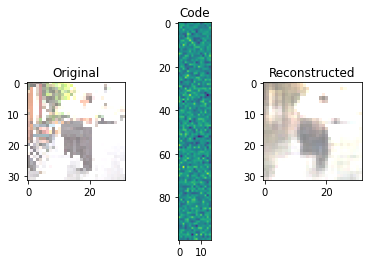

In [ ]:
visualize(x_test[15],encoder,decoder)

In [ ]:
images = np.concatenate((x_train, x_test), axis=0)
codes = encoder.predict(images)

Imagenes más parecidas

In [ ]:
from sklearn.neighbors import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)

NearestNeighbors(metric='euclidean')

In [ ]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)
    print(idx)
    return distances,images[idx]

In [ ]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=3)
    
    plt.figure(figsize=[8,7])
    plt.subplot(1,4,1)
    show_image(image)
    plt.title("Original image")
    
    for i in range(3):
        plt.subplot(1,4,i+2)
        show_image(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

[25441 15039 15956]


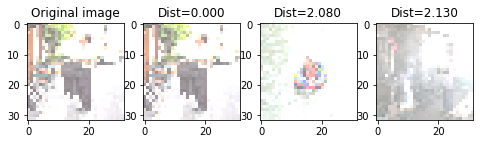

In [ ]:
show_similar(x_test[15])

In [ ]:
get_similar(x_test[5])[0].shape

[25431 28277 18212 16161  2590]


(5,)

[   20  9481 22059]


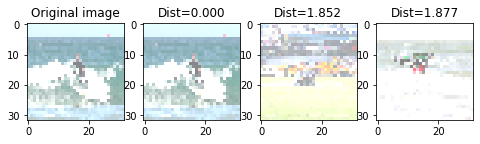

In [ ]:
show_similar(x_train[20])

In [ ]:
queries = [query.strip() for query in open("names_test_queries.csv", "r").readlines()]

[17517  6712  6847]


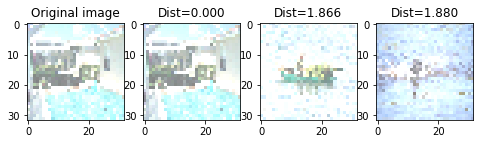

In [ ]:
show_similar(images[image_names.index(" " + queries[0])])

In [ ]:
def get_similar_indexes(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    _,(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)

    for i in range(len(idx)):#[*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*]
      if idx[i]>=11396:
          idx[i] +=1

    return idx


In [ ]:
import pandas as pd
import re

submission = pd.DataFrame(columns=["Id", "Expected"])

for query in queries:
    indice = int(query.split('image')[1].split('.')[0])#[*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*]
    indice = indice - 1 if indice >= 11396 else indice#[*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*]
    idx = get_similar_indexes(images[indice], 101)#[*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*]
    submission = submission.append({"Id": int(re.search(r'\d+', query).group()), "Expected": " ".join([str(x) for x in idx[1:]])}, ignore_index=True)#[*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*][*]

In [ ]:
submission

,Id,Expected
0,17518,6712 6847 3590 12582 3799 21756 23467 851 1991...
1,423,22507 1889 20469 4609 8769 9520 11693 27002 93...
2,13103,23021 22986 17945 6517 17770 4630 7160 22652 2...
3,16040,13364 15434 30465 3756 12516 4220 6517 11839 5...
4,25535,5783 5830 5062 28875 19952 24497 17945 26930 3...
...,...,...
856,30184,15040 26257 6976 4211 3756 16397 26629 9213 21...
857,19158,9638 21477 13755 7345 27495 25954 11151 9731 6...
858,28255,23369 5783 1700 4508 12345 13637 15416 3590 52...
859,23583,6154 2950 6007 21559 5818 27767 5062 27060 180...


In [ ]:
submission.to_csv("autoencoders_assimetric_submission_euclidean.csv", index=False)

# AutoEncoders + RBM 128 x 128

In [ ]:
import pandas as pd

def add_noise(data):
  noise_factor = 0.5
  data_noisy = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
  data_noisy = np.clip(data_noisy, 0., 1.)
  return data_noisy


files_df = pd.DataFrame(columns=["filename"], data=[path + name for name in image_names])
files_df  = files_df[files_df["filename"] != path + " image11396.jpg"]
train_noisy_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        validation_split=0.20,
        preprocessing_function=add_noise) 

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.20,
)

x_train = train_datagen.flow_from_dataframe(
    files_df, 
    batch_size = 32,
    target_size=(128,128),
    shuffle=False,
    subset='training',
    class_mode="input",
)

x_test = train_datagen.flow_from_dataframe(
    files_df, 
    batch_size = 32,
    target_size=(128,128),
    shuffle=False,
    subset='validation',
    class_mode="input",
)

Found 25427 validated image filenames.
Found 6356 validated image filenames.


In [ ]:
"""Implementation of a Restricted Boltzmann Machine"""
import torch

"""A set of generically helpful utility methods and constants"""
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
"""Which device to train the model on"""


def seed_everything(seed=42):
    """Seed everything to make the code more reproducable.
    This code is the same as that found from many public Kaggle kernels.
    Parameters
    ----------
    seed: int
        seed value to ues
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


def display_output(v0, vk, dim1=128, dim2=128, v0_fname=None, vk_fname=None):
    """Dsplaying the original and reconstructed images for comparison
    Parameters
    ----------
    v0: Tensor
        the original image
    vk: Tensor
        the reconstructed image
    dim1: int
        number of pixels on first dimension for plotting
    dim2: int
        number of pixels on second dimension for plotting
    v0_fname: str
        filename to save plot of original image in
    vk_fname: str
        filename to save plot of reconstructed image in
    """
    print("Original (top) and Reconstructed (bottom)")
    img = make_grid(v0.view(v0.shape[0], 1, dim1, dim2).data)
    npimg = np.transpose(img.detach().cpu().numpy(), (1, 2, 0))
    plt.imshow(npimg)
    if v0_fname is not None:
        plt.savefig(v0_fname)
    plt.show()
    img = make_grid(vk.view(vk.shape[0], 1, dim1, dim2).data)
    npimg = np.transpose(img.detach().cpu().numpy(), (1, 2, 0))
    plt.imshow(npimg)
    if vk_fname is not None:
        plt.savefig(vk_fname)    
    plt.show()


class RBM():
    """Implementation of a Restricted Boltzmann Machine
    
    Note that this implementation does not use Pytorch's nn.Module
    because we are updating the weights ourselves
    """
    def __init__(self, visible_dim, hidden_dim, gaussian_hidden_distribution=False):
        """Initialize a Restricted Boltzmann Machine
        Parameters
        ----------
        visible_dim: int
            number of dimensions in visible (input) layer
        hidden_dim: int
            number of dimensions in hidden layer
        gaussian_hidden_distribution: bool
            whether to use a Gaussian distribution for the values of the hidden dimension instead of a Bernoulli
        """
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        self.gaussian_hidden_distribution = gaussian_hidden_distribution

        # intialize parameters
        self.W = torch.randn(visible_dim, hidden_dim).to(DEVICE) * 0.1
        self.h_bias = torch.zeros(hidden_dim).to(DEVICE)  # v --> h
        self.v_bias = torch.zeros(visible_dim).to(DEVICE)  # h --> v

        # parameters for learning with momentum
        self.W_momentum = torch.zeros(visible_dim, hidden_dim).to(DEVICE)
        self.h_bias_momentum = torch.zeros(hidden_dim).to(DEVICE)  # v --> h
        self.v_bias_momentum = torch.zeros(visible_dim).to(DEVICE)  # h --> v

    def sample_h(self, v):
        """Get sample hidden values and activation probabilities
        Parameters
        ----------
        v: Tensor
            tensor of input from visible layer
        """
        activation = torch.mm(v, self.W).to(DEVICE)
        activation = activation + self.h_bias
        if self.gaussian_hidden_distribution:
            return activation, torch.normal(activation, torch.tensor([1]).to(DEVICE))
        else:
            p = torch.sigmoid(activation)
            return p, torch.bernoulli(p)

    def sample_v(self, h):
        """Get visible activation probabilities
        Parameters
        ----------
        h: Tensor
            tensor of input from hidden
        """
        activation = torch.mm(h, self.W.t()) + self.v_bias
        p = torch.sigmoid(activation)
        return p

    def update_weights(self, v0, vk, ph0, phk, lr, momentum_coef, weight_decay, batch_size):
        """Learning step: update parameters 
        Uses contrastive divergence algorithm as described in
        Parameters
        ----------
        v0: Tensor
            initial visible state
        vk: Tensor
            final visible state
        ph0: Tensor
            hidden activation probabilities for v0
        phk: Tensor
            hidden activation probabilities for vk
        lr: float
            learning rate
        momentum_coef: float
            coefficient to use for momentum
        weight_decay: float
            coefficient to use for weight decay
        batch_size: int
            size of each batch
        """
        self.W_momentum *= momentum_coef
        self.W_momentum += torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)

        self.h_bias_momentum *= momentum_coef
        self.h_bias_momentum += torch.sum((ph0 - phk), 0)

        self.v_bias_momentum *= momentum_coef
        self.v_bias_momentum += torch.sum((v0 - vk), 0)

        self.W += lr*self.W_momentum/batch_size
        self.h_bias += lr*self.h_bias_momentum/batch_size
        self.v_bias += lr*self.v_bias_momentum/batch_size

        self.W -= self.W * weight_decay # L2 weight decay

In [ ]:
def train_rbm(train_dl, visible_dim, hidden_dim, k, num_epochs, lr, use_gaussian=False):
    """Create and train an RBM
    
    Uses a custom strategy to have 0.5 momentum before epoch 5 and 0.9 momentum after
    
    Parameters
    ----------
    train_dl: DataLoader
        training data loader
    visible_dim: int
        number of dimensions in visible (input) layer
    hidden_dim: int
        number of dimensions in hidden layer
    k: int
        number of iterations to run for Gibbs sampling (often 1 is used)
    num_epochs: int
        number of epochs to run for
    lr: float
        learning rate
    use_gaussian:
        whether to use a Gaussian distribution for the hidden state
    
    Returns
    -------
    RBM, Tensor, Tensor
        a trained RBM model, sample input tensor, reconstructed activation probabilities for sample input tensor
    """
    rbm = RBM(visible_dim=visible_dim, hidden_dim=hidden_dim, gaussian_hidden_distribution=use_gaussian)
    loss = torch.nn.MSELoss() # we will use MSE loss

    for epoch in range(num_epochs):
        train_loss = 0
        for i, data_list in enumerate(train_dl):
            sample_data = data_list[0].to(DEVICE)
            v0, pvk = sample_data, sample_data
            
            # Gibbs sampling
            for i in range(k):
                _, hk = rbm.sample_h(pvk)
                pvk = rbm.sample_v(hk)
            
            # compute ph0 and phk for updating weights
            ph0, _ = rbm.sample_h(v0)
            phk, _ = rbm.sample_h(pvk)
            
            # update weights
            rbm.update_weights(v0, pvk, ph0, phk, lr, 
                               momentum_coef=0.5 if epoch < 5 else 0.9, 
                               weight_decay=2e-4, 
                               batch_size=sample_data.shape[0])

            # track loss
            train_loss += loss(v0, pvk)
        
        # print training loss
        print(f"epoch {epoch}: {train_loss/len(train_dl)}")
    return rbm, v0, pvk

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

trans = transforms.Compose([transforms.Resize((128, 128))])

visible_dim = 128  * 128
hidden_dim = None
models = [] # trained RBM models
import gc
gc.collect() # Python thing

def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = transforms.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

class CustomImageDataset(Dataset):
    def __init__(self, img_dir):
        self.img_labels = None
        self.img_dir = img_dir
        self.transform = trans

    def __len__(self):
        return len(os.listdir(path))

    def __getitem__(self, idx):
        try:
          img_path = os.path.join(self.img_dir, files_df.iloc[idx, 0])
        except IndexError:
            raise StopIteration
        image = read_image(img_path)
        image = self.transform(image)[0]
        return image, image

training_data = CustomImageDataset(img_dir=path) 
train_dl = DataLoader(training_data, batch_size=64, shuffle=False)
test_dl = DataLoader(training_data, batch_size=64, shuffle=False)
visible_dim = 128  * 128

def flatten_input(dl):
    flat_input = []
    labels = []
    for features, targets in train_dl:
        flat_input.append(features.view(-1, visible_dim).detach().cpu().numpy())
        labels.append(targets.detach().cpu().numpy())
    return np.concatenate(flat_input), np.concatenate(labels)

flat_train_input, train_labels = flatten_input(train_dl)
train_dl_flat = DataLoader(
    TensorDataset(torch.Tensor(flat_train_input).to(DEVICE)),
    batch_size=2,
    shuffle=False
)

In [ ]:
# get initial iteration of new training dl
new_train_dl = train_dl_flat

visible_dim = 128  * 128
hidden_dim = None
models = [] # trained RBM models

hidden_dimensions = [
    {
        "hidden_dim": 4000, 
        "num_epochs": 10, 
        "learning_rate": 0.1, 
        "display_dim1": 128, 
        "display_dim2": 128, 
        "use_gaussian": False
    }, 
    {
        "hidden_dim": 2000, 
        "num_epochs": 10, 
        "learning_rate": 0.1, 
        "display_dim1": 25, 
        "display_dim2": 40, 
        "use_gaussian": False
    },
    {
        "hidden_dim": 1000, 
        "num_epochs": 10, 
        "learning_rate": 0.1, 
        "display_dim1": 25, 
        "display_dim2": 20, 
        "use_gaussian": False
    },
    {
        "hidden_dim": 2, 
        "num_epochs": 30, 
        "learning_rate": 0.001, # use much lower LR for gaussian to avoid exploding gradient
        "display_dim1": 25, 
        "display_dim2": 10, 
        "use_gaussian": True # use a Gaussian distribution for the last hidden layer to let it take advantage of continuous values
    }
]

for configs in hidden_dimensions:
    
    # parse configs
    hidden_dim = configs["hidden_dim"]
    num_epochs = configs["num_epochs"]
    lr = configs["learning_rate"]
    d1 = configs["display_dim1"]
    d2 = configs["display_dim2"]
    use_gaussian = configs["use_gaussian"]
    
    # train RBM
    print(f"{visible_dim} to {hidden_dim}")
    model, v, v_pred = train_rbm(new_train_dl, visible_dim, hidden_dim, k=1, num_epochs=num_epochs, lr=lr, use_gaussian=use_gaussian)
    models.append(model)
    
    # display sample output
    display_output(v, v_pred, d1, d2)

    # rederive new data loader based on hidden activations of trained model
    new_data = []
    for data_list in new_train_dl:
        p = model.sample_h(data_list[0])[0]
        new_data.append(p.detach().cpu().numpy())
    new_input = np.concatenate(new_data)
    new_train_dl = DataLoader(
        TensorDataset(torch.Tensor(new_input).to(DEVICE)), 
        batch_size=64, 
        shuffle=False
    )
    
    # update new visible_dim for next RBM
    visible_dim = hidden_dim

16384 to 4000


KeyboardInterrupt: ignored

In [ ]:
rbm = RBM(visible_dim=visible_dim, hidden_dim=hidden_dim, gaussian_hidden_distribution=use_gaussian)